# 15 Redes Convolicionales en Código

In [1]:
import torch
import torch.nn as nn

In [2]:
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil    = ToPILImage() 

In [3]:
img = fv.PILImage.create( "storage/dark_art.jpg" )
img_tensor = to_tensor( img )

In [4]:
img_tensor.shape

torch.Size([3, 640, 640])

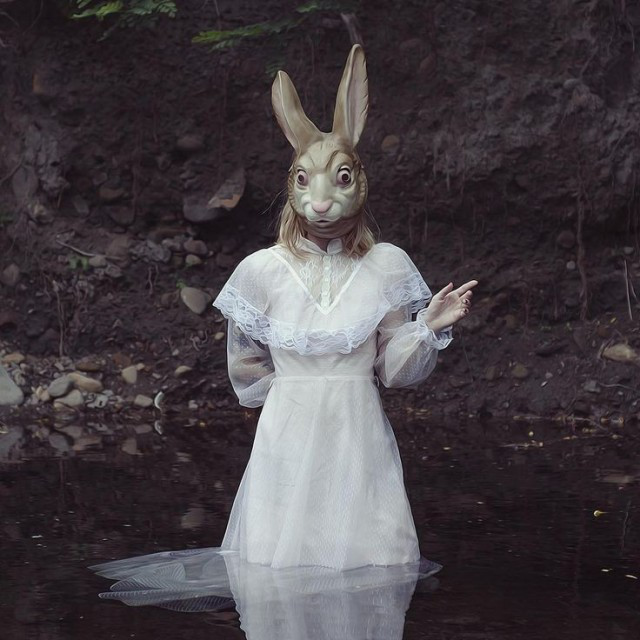

In [5]:
img

In [6]:
conv = nn.Conv2d( 3 , 1 , kernel_size = 3 )

Convolucion de tres filtros de entrada y uno de salida. Kernel, de cuanto por cuanto es el filtro

In [7]:
conv( img_tensor [None])

tensor([[[[0.4346, 0.4418, 0.4401,  ..., 0.3355, 0.3367, 0.3378],
          [0.3839, 0.3875, 0.3847,  ..., 0.3415, 0.3483, 0.3400],
          [0.3199, 0.3209, 0.3189,  ..., 0.3315, 0.3457, 0.3414],
          ...,
          [0.3331, 0.3406, 0.3372,  ..., 0.3161, 0.3127, 0.3129],
          [0.3317, 0.3380, 0.3397,  ..., 0.3145, 0.3035, 0.3018],
          [0.3250, 0.3294, 0.3326,  ..., 0.3041, 0.2915, 0.2862]]]],
       grad_fn=<MkldnnConvolutionBackward>)

Agregamos una dimension para pasarlo a batches. Es un batch de tamaño 1

In [8]:
conv( img_tensor [None]).shape

torch.Size([1, 1, 638, 638])

Les quita dos pixeles porque la matriz de convolucion es de 3x3 y por principo de casillas les quita en las orillas para poder calcular la matriz.
- batch tamaño 1
- salida definida de una dimension
- alto
- ancho


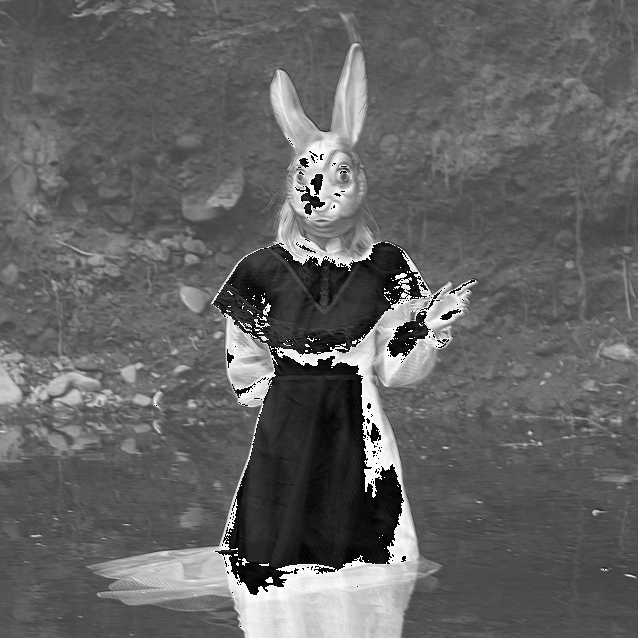

In [9]:
a = conv( img_tensor [None])
f = to_pil(a[0])
f

Visualizamos la imagen, pero no nos dice nada específico porque los números de la convolución fueron generados aleatoriamente

In [19]:
#Esta capa servirá para conectar las convolucionales con las lineales (densas)

#--Funciones de ayuda--#
##Flatten es una capa que ayuda a pasar de la parte convolucional a la parte lineal

#Lo que hace la clase es que le pasamos algo y nos regresa eso mismo pero sin los 1
class Flatten(nn.Module):   #Creamos un módulo que hereda de nn.Module
    def __init__(self):    #Para crear un objeto
        super().__init__() #Le decimos a nn.Module que se inicie
    
    def forward( self, x ): #
        return x.squeeze()

#--Para tener idea de qué tan grande es nuestro modelo--#
def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
            total += num
    return total        

In [34]:
#Primer intento Red Neuronal Convolucional hecha a Mano
model  = nn.Sequential( #Sequential para cosas sencillas
    
    #Convolucion de entrada 3, de 32 filtros, de tamaño 3x3, 
    #sride -> ¿cuánto brinca?, padding -> pone el brde negro para no perder pixeles
    nn.Conv2d( 3, 32, kernel_size = 3, stride = 2, padding = 1),
    
    #Acivacion
    nn.ReLU(),
    
    #Reducir el tamaño de a  imagen (será más rápido)
    #Cada cuadro de 2x2 agarra el más grande.
    #Reduce a la mitad
    nn.MaxPool2d(2),
    
    #Empezamos en la cantidad de filtros con los que acabamos en Conv2d anterior
    nn.Conv2d( 32, 64, kernel_size = 3, stride = 1, padding = 1),
    
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 256, 512, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    #--Aquí acabamos con la parte convolucional--#
    
    #--Llegamos a la parte lineal--#
    
    nn.AdaptiveAvgPool2d(1), #Reducir el tamaño a 1x1xn_canales
    #Podemos usar diferentes métodos para llegar a 1x1
    Flatten(), #Usamos la funcion que habiamos creado pra eliminar las de dim 1
    #Los quita para poder usar Linear
    nn.Linear( 512, 256), #Completamente conectada
    nn.ReLU(),
    nn.Linear( 256, data.c) #salida con el total de clases de los datos
)

In [35]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): AdaptiveAvgPool2d(output_size=1)
  (15): Flatten()
  (16): Linear(in_features=512, out_features=256, bias=True)
  (17): ReLU()
  (18): Linear(in_features=256, out_features=200, bias=True)
)

El modelo es todo eso

In [24]:
num_params(model)

2424172

El total de parámetros

Creamos una imagen para porobar el modelo

In [25]:
img = torch.rand ( 10, 3, 256, 256)

In [26]:
model( img ).shape

torch.Size([10, 102])

tam_batch, features

In [28]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

In [29]:
! unzip storage/birds(small).zip

/bin/sh: 1: Syntax error: "(" unexpected


In [30]:
data = load_data( "storage/birds/", 256, 64 )

In [36]:
#Numero de clases
data.c

200

###### Ahora creamos el aprendedor

In [37]:
learn = fv.Learner( data, model, metrics = fv.accuracy )

In [39]:
learn.summary()
#Agarra una batch, la manda y va viendo de qué tamaño tiene cada parte las imágenes

Sequential (Input shape: ['64 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 128 x 128  896        True      
________________________________________________________________
ReLU                 64 x 32 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            64 x 32 x 64 x 64    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 64    18,496     True      
________________________________________________________________
ReLU                 64 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               64 x 128 x 32 x 32   73,856     True      
_________________________________________________

Muestra todas las capas y qué tamaño tienen las imágenes después de pasar por cada capa

#### Ahora vamos a entrenar 

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=0.25118863582611084)

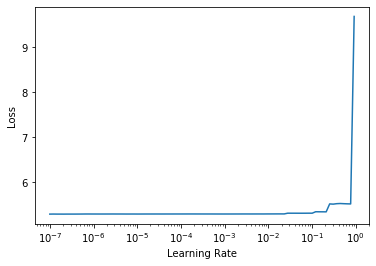

In [42]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(4, 1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,5.298994,5.298947,0.005178,00:19
1,5.299120,5.298889,0.005178,00:19
2,5.298818,5.298851,0.005178,00:19
3,5.299024,5.298845,0.005178,00:18


#### SI comaparamos los resultados con los de resnet 18:
    - Nuestro modelo es más pequeño, más sencillo
    - Empezamos con pesos aleatirios, resnet ya estaba preentrenado
    - No nos ponemos a optimizar cosas

### Ya podemos hacer cualquier modelo que se nos ocurra